# Wk 3 discussion hw

In [1]:
# !conda update -n base conda
# !conda install -c conda-forge imbalanced-learn


In [2]:
import pandas as pd
from zipfile import ZipFile
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np

In [3]:
zip_file = ZipFile('../../data/raw/forStudents.pkl.zip')
df = pd.read_pickle(zip_file.open('forStudents.pkl'))
df

,acquisition_type,snapshot_type,channel,evaluation_dt,vintage,is_app_approved,vantage3_score,bad,bad_v2,bad_balance,...,rtr5930,rtr7110,rtr7140,rtr7160,rtr7216,rtr7620,rtr8120,rtr8220,rtr8320,rowNumber
0,ORGANIC,FLOW_MODULARITY,OTHER,2021-08-04,202108,1,698.0,0.0,0.0,0.0,...,2.0,4.0,4.0,9.0,5.0,100.0,5.0,5.0,5.0,59486
1,ORGANIC,FLOW_MODULARITY,OTHER,2021-03-01,202103,1,731.0,0.0,0.0,0.0,...,30.0,2.0,2.0,130.0,12.0,100.0,4.0,4.0,4.0,2357
2,ORGANIC,FLOW_MODULARITY,OTHER,2021-02-26,202102,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90398
3,ORGANIC,FLOW_MODULARITY,OTHER,2021-06-04,202106,1,715.0,0.0,0.0,0.0,...,249.0,18.0,18.0,56.0,7.0,100.0,5.0,151.0,45.0,104654
4,ORGANIC,FLOW_MODULARITY,OTHER,2021-07-14,202107,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48707,ORGANIC,FLOW_MODULARITY,OTHER,2021-05-01,202105,1,732.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,131881
48708,ORGANIC,FLOW_MODULARITY,OTHER,2020-11-29,202011,1,705.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,47197
48709,ORGANIC,FLOW_MODULARITY,OTHER,2021-04-25,202104,1,722.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,2.0,167.0,86.0,29739
48710,ORGANIC,FLOW_MODULARITY,OTHER,2021-04-10,202104,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89207


In [4]:
# Clean and imputation

df_clean = df[df['all0000'].notna()]
df_clean = df_clean[df_clean['bad'] != -1.0]
df_clean = df_clean[df_clean['is_app_approved'] == 1]
df_clean.drop(columns=['bad_v2','evaluation_dt','vintage'], inplace=True)
described = df_clean["annual_income"].describe()
quartiles = list(described.iloc[4:7])

In [5]:
def assign_quartile(row):
    income = row["annual_income"]
    if income < quartiles[0]:
        return 0
    elif ((quartiles[0] < income) & (quartiles[1] >= income)):
        return 1
    elif ((quartiles[1] < income) & (quartiles[2] >= income)):
        return 2
    else:
        return 3

In [6]:
df_clean.apply(assign_quartile, axis=1).value_counts().sort_index()

0    10625
1    10546
2    10709
3    10667
dtype: int64

In [7]:
df_clean['income_quartile'] = df_clean.apply(assign_quartile, axis=1)

In [8]:
dfs = []
for i in range(4):
    quartile = df_clean.loc[df_clean["income_quartile"] == i]
    dfs.append(quartile.fillna(quartile.mean()))
    
df_clean = pd.concat(dfs)

temp = df_clean.isna().sum().to_frame()
temp[temp[0] != 0]

df_clean.drop(columns=['all9230', 'all9240', 'all9249', 'all9280'], inplace=True)
df_clean = df_clean.fillna(df_clean.mean())

<ipython-input-8-d247c70cf6b6>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfs.append(quartile.fillna(quartile.mean()))
<ipython-input-8-d247c70cf6b6>:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_clean = df_clean.fillna(df_clean.mean())


In [9]:
# Categorical

def process_categorical_data(dataset):
    """ One hot encodes all of the categorial columns of the dataset.  Removes the original columns """
    # select categorical data
    categorical_data = dataset.select_dtypes('object')
    
    enc = OneHotEncoder(handle_unknown='ignore')
    
    ohe_data = enc.fit_transform(categorical_data).toarray()
    column_names = enc.get_feature_names(categorical_data.columns)
    
    add = dataset.select_dtypes(exclude='object')
    added = pd.DataFrame(ohe_data,columns=column_names).astype(int)
    
    add.reset_index(drop = True, inplace= True)
    added.reset_index(drop = True, inplace= True)
    X = pd.concat([add, 
               added], axis=1)
    print(X.shape)
    return X

df_clean = process_categorical_data(df_clean)
df_clean

/Users/nathanvanlingen/miniforge3/envs/test/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(42547, 891)


,is_app_approved,vantage3_score,bad,bad_balance,current_balance,net_spend,annual_income,all0000,all0060,all0061,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
0,1,698.0,0.0,0.0,0.00,5.51,15171,10.0,8.000000,8.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,731.0,0.0,0.0,30.95,30.95,20000,3.0,4.165954,5.237061,...,0,0,0,0,0,0,0,0,0,0
2,1,701.0,0.0,0.0,0.00,0.00,7000,6.0,4.165954,5.237061,...,0,0,0,0,0,0,0,0,0,0
3,1,655.0,1.0,870.6,870.60,0.00,18000,3.0,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,1,665.0,0.0,0.0,784.55,0.00,30000,6.0,4.165954,5.237061,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42542,1,651.0,0.0,0.0,2593.57,243.18,125000,12.0,9.305257,11.139763,...,0,0,0,0,0,0,0,0,0,0
42543,1,635.0,0.0,0.0,971.05,971.05,101000,60.0,21.000000,11.139763,...,0,0,0,0,0,0,0,0,0,0
42544,1,628.0,0.0,0.0,0.00,0.00,145000,53.0,9.305257,11.139763,...,0,0,0,0,0,0,0,0,0,0
42545,1,642.0,0.0,0.0,0.00,0.00,72000,7.0,9.305257,11.139763,...,0,0,0,0,0,0,1,0,0,0


In [10]:
# Imbalance dataset

# oversample = SMOTE()
X = df_clean.drop('bad', axis=1)
y = df_clean['bad'].astype(int)
# counter = Counter(y)
# print(counter)
# X, y = oversample.fit_resample(X, y)
# counter = Counter(y)
# print(counter)

## Train logistic regression model

In [11]:
# Splitting Dataset
from sklearn.linear_model import LogisticRegression
# X = df_clean.drop('bad', axis=1)
# y = df_clean[['bad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(penalty='none').fit(X_train,y_train)
y_pred =clf.predict(X_test)


/Users/nathanvanlingen/miniforge3/envs/test/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[11519,   123],
       [  794,   329]])

### Precision, recall, f1 score, accuracy metrics

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     11642
           1       0.73      0.29      0.42      1123

    accuracy                           0.93     12765
   macro avg       0.83      0.64      0.69     12765
weighted avg       0.92      0.93      0.91     12765



### Plotting ROC on train/test + train/test auc scores

In [14]:
clf.predict_proba(X_test).T[1].shape


(12765,)

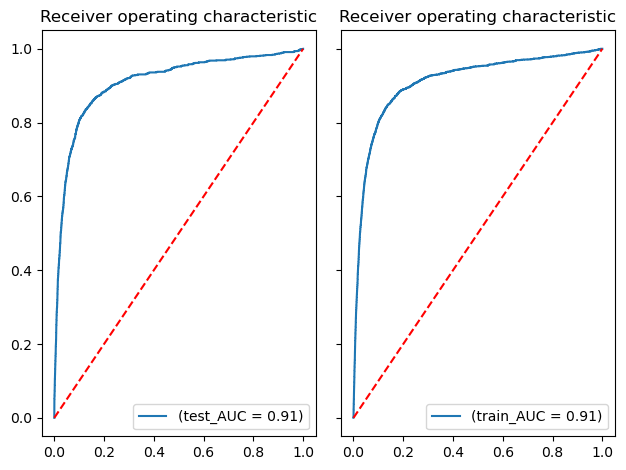

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1, 2, sharey=True)

logit_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
# plt.figure()
axes[0].plot(fpr, tpr, label='(test_AUC = %0.2f)' % logit_roc_auc)
axes[0].plot([0, 1], [0, 1],'r--')
# axes[0].xlim([0.0, 1.0])
# axes[0].ylim([0.0, 1.05])
# axes[0].xlabel('False Positive Rate')
# axes[0].ylabel('True Positive Rate')
axes[0].title.set_text('Receiver operating characteristic')
axes[0].legend(loc="lower right")
# axes[0].savefig('Log_ROC')
# axes[0].show()

logit_roc_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
plt.figure()
axes[1].plot(fpr, tpr, label='(train_AUC = %0.2f)' % logit_roc_auc)
axes[1].plot([0, 1], [0, 1],'r--')
# axes[1].xlim([0.0, 1.0])
# axes[1].ylim([0.0, 1.05])
# axes[1].xlabel('False Positive Rate')
# axes[1].ylabel('True Positive Rate')
axes[1].title.set_text('Receiver operating characteristic')
axes[1].legend(loc="lower right")
# axes[1].savefig('Log_ROC')
# axes[1].show()
fig.tight_layout()

plt.show()

### AUC on worst scoring 30%

In [16]:
logit_roc_auc = roc_auc_score(y_test, y_pred, max_fpr = 0.3)

print(f'AUC on worst scoring 30%: {logit_roc_auc}')

AUC on worst scoring 30%: 0.6397514297302714


### Plotting reliability diagram on train/test + ece score

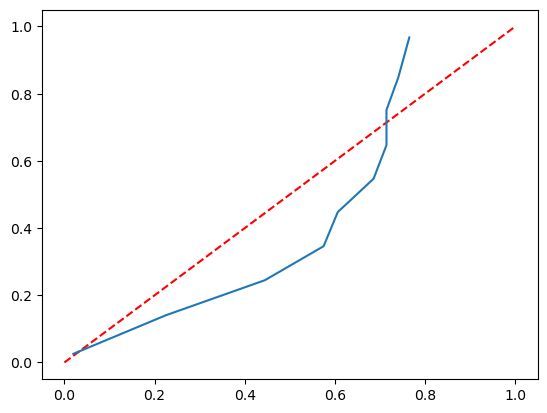

0.1231050844442099


In [17]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_train, clf.predict_proba(X_train)[:,1], n_bins=10, normalize = True)

plt.plot([0, 1], [0, 1],'r--')
plt.plot(prob_true, prob_pred)
plt.show()


ece = np.sum(np.abs(prob_true - prob_pred) * ((len(y_test)/10) / len(y_test)))
print(ece)

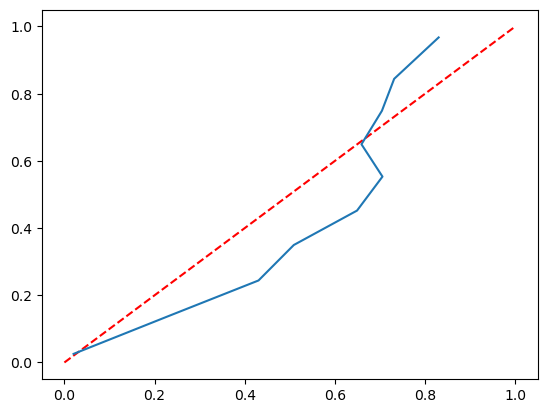

0.10984235059611391


In [18]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, clf.predict_proba(X_test)[:,1], n_bins=10)

plt.plot([0, 1], [0, 1],'r--')
plt.plot(prob_true, prob_pred)
plt.show()


ece = np.sum(np.abs(prob_true - prob_pred) * ((len(y_test)/10) / len(y_test)))
print(ece)

### Compute loss 

In [19]:
from sklearn.metrics import log_loss

print(f'log loss: {log_loss(y_test, clf.predict_proba(X_test))}')

log loss: 0.19275144056046306


### Compute dollar loss prevented

In [20]:
# dollar loss prevented
X_test['predicted_bad'] = y_pred
X_test[(y_test == 1) & (y_test == y_pred)]['bad_balance'].sum().round(2)

632149.59

#### Discuss with your group some pros/cons of different evaluation metrics



Accuracy:
Pros: gives us a general idea of how our model is performing based on the overall correctness of predictions
Cons: does not account for class imbalance, if our model guessed that nobody would default then it would be ~90% accurate, does not account for dollar loss due to defaulting

Precision / Recall / F1-score:
Pros: better than accuracy, precision and recall measure the performance for each class independently, f1 score combines precision and recall
Cons: do not account for dollar loss due to defaulting, not as relevant to business stakeholders

dollar loss prevented:
Pros: accounts for dollar loss due to defaulting, extremely relevant to business stakeholders
Cons: the baseline we used was giving everyone a loan, this may not be realistic (solution would be to use this logistic regression as a baseline and compare the dollar loss in our future models to this model)


# Feature Selection

Feature Selection Techniques(?): <br>

Information Gain, Gain-Ratio, Chi-Square, 

In [21]:
# TODO: balance df_clean
df_clean_0 = df_clean[df_clean['bad'] == 0.0]
df_clean_1 = df_clean[df_clean['bad'] == 1.0]

df_clean_0_sample = df_clean_0.sample(n=len(df_clean_1), replace=False, random_state = 42)
df_clean_balanced = pd.concat([df_clean_0_sample, df_clean_1])

len(df_clean_balanced) # should be 3693 * 2 = 7386



7386

In [22]:
X = df_clean_balanced.drop('bad', axis=1)
y = df_clean_balanced['bad'].astype(int)

## Feature Importance

In [23]:
X = X.drop('vantage3_score', axis=1).drop('bad_balance', axis=1).drop('is_app_approved',axis=1)

In [24]:
top_col_idx = abs(clf.coef_[0]).argsort()[-50:]
top_col_idx

array([163, 560, 697, 645, 149, 490, 648, 347, 552, 812, 644, 348, 499,
       469, 758,   1, 559, 166, 814, 813, 278, 315, 164, 695, 524, 313,
       701, 171, 759, 332, 719, 757, 760, 720, 275, 680, 718, 722, 652,
         4, 721, 761, 314, 276, 696, 698, 501, 502,   3,   2])

In [25]:
def model_evaluator(data):
    X = data.drop('bad', axis=1)
    y = data['bad'].astype(int)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = LogisticRegression(penalty='none').fit(X_train,y_train)
    y_pred =clf.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    X_test['predicted_bad'] = y_pred
#     print("Dollar Loss: " + str(X_test[(y_test == 1) & (y_test == y_pred)]['bad_balance'].sum().round(2)))

In [26]:
top50 = X.iloc[:,top_col_idx]
top50['bad'] = y

<ipython-input-26-0752eb84970f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50['bad'] = y


In [27]:
# top50 = X.iloc[:,scores.argsort()[:1]]
# top50['bad'] = y


In [28]:
model_evaluator(top50)

/Users/nathanvanlingen/miniforge3/envs/test/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[578 545]
 [347 746]]
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      1123
           1       0.58      0.68      0.63      1093

    accuracy                           0.60      2216
   macro avg       0.60      0.60      0.60      2216
weighted avg       0.60      0.60      0.59      2216



## chi-sq select k best

In [29]:
from sklearn.feature_selection import SelectKBest, chi2

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_normalized = scaler.fit_transform(X)

In [31]:
X_new = pd.DataFrame(SelectKBest(chi2, k=50).fit_transform(X_normalized, y))
X_new['bad'] = y

model_evaluator(top50)

[[623 478]
 [293 822]]
              precision    recall  f1-score   support

           0       0.68      0.57      0.62      1101
           1       0.63      0.74      0.68      1115

    accuracy                           0.65      2216
   macro avg       0.66      0.65      0.65      2216
weighted avg       0.66      0.65      0.65      2216



/Users/nathanvanlingen/miniforge3/envs/test/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


What are your top 50 features?  Top 10 features?

In [32]:
# Top 50 features with feature importance

X.iloc[:, top_col_idx]

,all5460,iln5823,brc5838,bcc5239,all5043,rta7110,bcc5423,hlc6201,iln5047,rtr5920,...,reh5830,rev5047,mta5743,mfx5829,brc5830,brc5930,fip0416,fip0438,all0000,annual_income
6754,0.0,92.528256,25.000000,0.000000,0.0,24.641062,6000.000000,11.851442,0.000000,96.126175,...,60.0,0.0,0.0,445.769841,60.0,249.0,0.551532,0.537604,9.0,24037
1983,0.0,92.528256,28.000000,23.000000,0.0,24.641062,3800.000000,11.851442,0.001599,96.126175,...,88.0,0.0,0.0,445.769841,88.0,28.0,0.551532,0.537604,4.0,29000
25807,388.0,127.153277,0.000000,0.000000,0.0,0.000000,700.000000,10.666667,0.000000,29.000000,...,60.0,0.0,0.0,789.483633,60.0,231.0,1.000000,1.000000,9.0,55000
25211,208.0,127.153277,130.000000,587.000000,0.0,26.751018,1000.000000,10.666667,0.000000,160.930790,...,167.0,0.0,0.0,789.483633,167.0,430.0,0.687990,0.653893,15.0,54800
23604,0.0,25.000000,103.988262,1256.727934,0.0,26.751018,500.000000,10.666667,0.000000,160.930790,...,25.0,0.0,0.0,789.483633,25.0,0.0,0.687990,0.653893,7.0,48000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42477,0.0,177.063368,165.000000,9546.000000,0.0,0.000000,9900.000000,23.769231,0.000000,0.000000,...,363.0,0.0,0.0,1101.051404,363.0,200.0,0.000000,0.000000,16.0,100000
42490,0.0,177.063368,128.255038,1692.198759,0.0,25.326432,4651.317744,23.769231,0.000000,225.433103,...,0.0,0.0,0.0,1101.051404,0.0,0.0,1.000000,1.000000,18.0,75000
42494,0.0,177.063368,3.000000,0.000000,0.0,0.000000,500.000000,23.769231,0.000000,0.000000,...,3.0,0.0,0.0,1101.051404,3.0,602.0,1.000000,1.000000,26.0,105000
42520,1000.0,568.000000,189.000000,5087.000000,0.0,25.326432,8200.000000,23.769231,0.000000,225.433103,...,236.0,0.0,0.0,1101.051404,236.0,2588.0,0.759844,0.702999,14.0,69000


In [33]:
# Top 10 features
X.iloc[:, top_col_idx[-10:]]

,reh5830,rev5047,mta5743,mfx5829,brc5830,brc5930,fip0416,fip0438,all0000,annual_income
6754,60.0,0.0,0.0,445.769841,60.0,249.0,0.551532,0.537604,9.0,24037
1983,88.0,0.0,0.0,445.769841,88.0,28.0,0.551532,0.537604,4.0,29000
25807,60.0,0.0,0.0,789.483633,60.0,231.0,1.000000,1.000000,9.0,55000
25211,167.0,0.0,0.0,789.483633,167.0,430.0,0.687990,0.653893,15.0,54800
23604,25.0,0.0,0.0,789.483633,25.0,0.0,0.687990,0.653893,7.0,48000
...,...,...,...,...,...,...,...,...,...,...
42477,363.0,0.0,0.0,1101.051404,363.0,200.0,0.000000,0.000000,16.0,100000
42490,0.0,0.0,0.0,1101.051404,0.0,0.0,1.000000,1.000000,18.0,75000
42494,3.0,0.0,0.0,1101.051404,3.0,602.0,1.000000,1.000000,26.0,105000
42520,236.0,0.0,0.0,1101.051404,236.0,2588.0,0.759844,0.702999,14.0,69000


In [34]:
model_evaluator(top50)

[[574 549]
 [285 808]]
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      1123
           1       0.60      0.74      0.66      1093

    accuracy                           0.62      2216
   macro avg       0.63      0.63      0.62      2216
weighted avg       0.63      0.62      0.62      2216



/Users/nathanvanlingen/miniforge3/envs/test/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
top10 = X.iloc[:,top_col_idx[-10:]]
top10['bad'] = y

<ipython-input-35-a2b3646ba1a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['bad'] = y


In [36]:
top10

,reh5830,rev5047,mta5743,mfx5829,brc5830,brc5930,fip0416,fip0438,all0000,annual_income,bad
6754,60.0,0.0,0.0,445.769841,60.0,249.0,0.551532,0.537604,9.0,24037,0
1983,88.0,0.0,0.0,445.769841,88.0,28.0,0.551532,0.537604,4.0,29000,0
25807,60.0,0.0,0.0,789.483633,60.0,231.0,1.000000,1.000000,9.0,55000,0
25211,167.0,0.0,0.0,789.483633,167.0,430.0,0.687990,0.653893,15.0,54800,0
23604,25.0,0.0,0.0,789.483633,25.0,0.0,0.687990,0.653893,7.0,48000,0
...,...,...,...,...,...,...,...,...,...,...,...
42477,363.0,0.0,0.0,1101.051404,363.0,200.0,0.000000,0.000000,16.0,100000,1
42490,0.0,0.0,0.0,1101.051404,0.0,0.0,1.000000,1.000000,18.0,75000,1
42494,3.0,0.0,0.0,1101.051404,3.0,602.0,1.000000,1.000000,26.0,105000,1
42520,236.0,0.0,0.0,1101.051404,236.0,2588.0,0.759844,0.702999,14.0,69000,1


In [37]:
model_evaluator(top10)

[[1025   70]
 [1048   73]]
              precision    recall  f1-score   support

           0       0.49      0.94      0.65      1095
           1       0.51      0.07      0.12      1121

    accuracy                           0.50      2216
   macro avg       0.50      0.50      0.38      2216
weighted avg       0.50      0.50      0.38      2216



Features we dropped include dates, and features like bad_balance and vantage3_score which have direct relation to our outcome variable bad